# COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

# covidtracking.columns

In [4]:
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']
df_state = df_state.sort_values('date', ascending=True)

# df_state.state.unique()

In [5]:
# Load in state population counts and merge with ctp data
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') 
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!

date                0
state               0
fips                0
positiveIncrease    0
deathIncrease       0
negativeIncrease    0
State               0
Code                0
Population          0
CVD_group           0
dtype: int64

In [6]:
# Create state groupings (currently a manual process based on death rates over certain time periods)

grouped_cvd = df_state.groupby(['CVD_group', 'date']).sum().reset_index()
grouped_cvd = grouped_cvd.drop('Population', axis=1)

group_population = st_population.groupby('CVD_group').sum().reset_index()
grouped_cvd = grouped_cvd.merge(group_population, on='CVD_group')
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

## Comparing infection estimate from seroprevalence to actual case rate
- The CDC has been conducting seroprevalence surveys (prevalence of antibodies to COVID in blood samples) in people across the country. They provide estimates on their website of the total people who have been infected. These estimates are several times more than the number of diagnosed cases based on antigen testing (such as the common PCR nasal swab test). This is important since the diagnosed case numbers are reported everywhere even though they are significant understatements of the actual number of infections.
- Seroprevalence data source: https://data.cdc.gov/Laboratory-Surveillance/Nationwide-Commercial-Laboratory-Seroprevalence-Su/d2tw-32xv/data
- The code below explores the comparison between the infection estimates from seroprevalence tests and diagnoses cases from antigen tests. Is there a reasonable method for weighting diagnosed cases to come up with a reliable estimate of actual infections? Antigen testing capacity was scarce in the early months of the epidemic. Those states with early outbreaks have the highest disparity between estimated infections and diagnosed cases. Are there other obvious disparities? Can this information be used to create reliable estimates of infections?

In [7]:
seroprev = pd.read_csv('../data/Nationwide_Commercial_Laboratory_Seroprevalence_Survey_November.csv')[['Site', 'Date Range of Specimen Collection', 'Round', 'Estimated cumulative infections count']]
seroprev.head(2)

,Site,Date Range of Specimen Collection,Round,Estimated cumulative infections count
0,AK,"Aug 6 - Aug 11, 2020",1,2216.0
1,AL,"Jul 29 - Aug 13, 2020",1,282151.0


In [8]:
## Checking to be sure each round is a stand-alone prediction. It appears to be so.
checker = pd.read_csv('../data/Nationwide_Commercial_Laboratory_Seroprevalence_Survey_November.csv')[
    ['Site', 'n [Cumulative Prevalence]', 'Round']]
checker[checker['Site']=='NY']

,Site,n [Cumulative Prevalence],Round
34,NY,846,1
86,NY,1122,2
139,NY,1043,3
191,NY,1168,4
243,NY,822,5
295,NY,820,6
347,NY,1355,7
399,NY,1199,8


### Data discussion
Some time was spent looking at this dataset to understand what it contained. We loaded just the columns that we needed. Those columns include the Site, aka state, 

We need to convert the date range for each round to a usable format. The specimen collection windows differ slightly by state. Let's find the latest closing date for a given round to use as our marker. 

In [9]:
seroprev['date_range_top'] = pd.to_datetime(seroprev['Date Range of Specimen Collection'].
                                str[-12:].str.strip())
round_dates = (seroprev.groupby('Round').agg(
                                date_range_top = ('date_range_top', 'max'))
                                ) #.reset_index()

In [10]:
round_dates['date_range_top']

Round
1   2020-08-13
2   2020-08-27
3   2020-09-10
4   2020-09-24
5   2020-10-08
6   2020-10-22
7   2020-11-15
8   2020-11-29
Name: date_range_top, dtype: datetime64[ns]

The seroprevalence dataset provides an estimated infections count for each state based on seroprevalence statistics collected during that particular round. Let's compare that the cumulative COVID cases. For this project we are going to use the COVID diagnosis data from the COVID Tracking project. We are going to load in just the columns we may need and then do some date formatting.

In [11]:
# Load in the COVID Tracking Project dataset by date and by state for US
df_cases = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")[
                                ['date', 'state', 'fips','positiveIncrease']]

df_cases['date'] = pd.to_datetime(df_cases['date'], format='%Y%m%d')
df_cases['date']

# df_cases = df_cases[df_cases['date'] >= '2020-03-10']
df_cases = df_cases.sort_values('date', ascending=True)
df_cases

,date,state,fips,positiveIncrease
18081,2020-01-13,WA,53,0
18080,2020-01-14,WA,53,0
18079,2020-01-15,WA,53,0
18078,2020-01-16,WA,53,0
18077,2020-01-17,WA,53,0
...,...,...,...,...
32,2021-01-18,NE,31,1068
31,2021-01-18,ND,38,70
30,2021-01-18,NC,37,0
28,2021-01-18,MS,28,1457


We then sum up cumulative cases for each state coinciding with the dates that closed out each seroprevalence study  round. We can then create a new master dataset by merging the case data with the original seroprevalence dataset. 

In [12]:
temp_case_df = []
for round in range(len(round_dates)):
    round_df = (df_cases[df_cases['date'] <= round_dates.iloc[round][0]].
                   groupby('state').
                   agg(cumulative_cases = ('positiveIncrease','sum'))
                    ).reset_index()
    round_df['round'] = round + 1
    temp_case_df.append(round_df)

case_df = pd.concat(temp_case_df, ignore_index=True)

In [13]:
master_df = seroprev.merge(case_df, left_on=['Site', 'Round'], right_on=['state', 'round'])

In [14]:
master_df

,Site,Date Range of Specimen Collection,Round,Estimated cumulative infections count,date_range_top,state,cumulative_cases,round
0,AK,"Aug 6 - Aug 11, 2020",1,2216.0,2020-08-11,AK,3978,1
1,AL,"Jul 29 - Aug 13, 2020",1,282151.0,2020-08-13,AL,105557,1
2,AR,"Jul 29 - Aug 13, 2020",1,122618.0,2020-08-13,AR,51766,1
3,AZ,"Jul 31 - Aug 11, 2020",1,569628.0,2020-08-11,AZ,190792,1
4,CA,"Jul 30 - Aug 5, 2020",1,2231479.0,2020-08-05,CA,593088,1
...,...,...,...,...,...,...,...,...
411,VA,"Nov 12 - Nov 26, 2020",8,387034.0,2020-11-26,VA,235942,8
412,VT,"Nov 16 - Nov 28, 2020",8,3750.0,2020-11-28,VT,4225,8
413,WI,"Nov 9 - Nov 25, 2020",8,901429.0,2020-11-25,WI,409054,8
414,WV,"Nov 16 - Nov 27, 2020",8,65846.0,2020-11-27,WV,46997,8


Now it's time for some statistics. The estimated cumulative infections were calculated based only upon data collected from that round for each particular state. Let's calculate an *undercount rate* from this data by dividing estimated cumulative infections by cumulative diagnosed cases. *What does this distribution of these independent samples look like?* If it is normally distributed then we might be able to assume that a single probability function underlies all of the data. That would be helpful if it were true. If so, we could apply the overall sample mean as a weight to case diagnoses to calculate estimated infections for each state. 
 

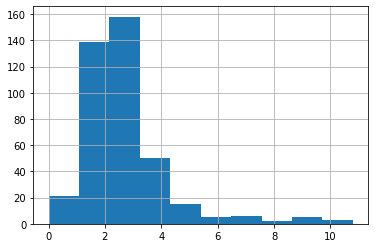

In [15]:
# This is somewhat promising because the distribution of the undercount_rate has a normal appearance with a tail. 
master_df['undercount_rate'] = master_df['Estimated cumulative infections count'] / master_df['cumulative_cases']
master_df['undercount_rate'].hist();

While the histogram is (somewhat) normally distributed, we need to dig a little further. Data was collected from 50 states over eight different rounds, or time periods. One test for randomness would be to see if a state's undercount rate was consistently over, or under, the overall undercount rate over the eight different rounds. Randomness would mean that the undercount rate for a given state and given round would have an equal probability of being over or under the overall mean. 

The chart below shows this isn't the case. Each line plots the undercount rate for one state over the eight rounds. (State names aren't displayed to minimize clutter.) States are color coded according to whether the average undercount rate for that state falls above (noted with a blue line) or below (gold line) the overall underount rate. There is a clear pattern. The undercount rates for some states consistently fall above the overall average undercount rate and others fall consistently fall below it. This suggests that each state may have its own undercount rate probability function. This implies that things that vary by state like population dynamics, test facility availability, etc. may play a role in determining a state's case diagnosis undercount rate. While it may not be perfect, a reasonable approach may be to use each state's unique average undercount rate to estimate infections from case diagnoses.

There's a second thing to note about the chart. The lines for the three states with the two highest undercount rates--they happen to be New York, Pennsylvania, and New Jersey--trend downwards from Round 1 to Round 8. What is going on here? This is pretty straightforward. All three states were hit early and hard with COVID at a time when COVID case testing capabilities were unprepared to meet demand. Many infections went undiagnosed in those early stages until testing capacity increased. As time progressed and a higher percentage of infections were diagnosed, the percentage of undiagnosed infections as a percentage of total infections decreased. This suggests that it may be reasonable to use a different undercount rate for the first several months of the outbreak. It may also be reasonable to assume that undercounting was most severe for those three states which were severely impacted early on.

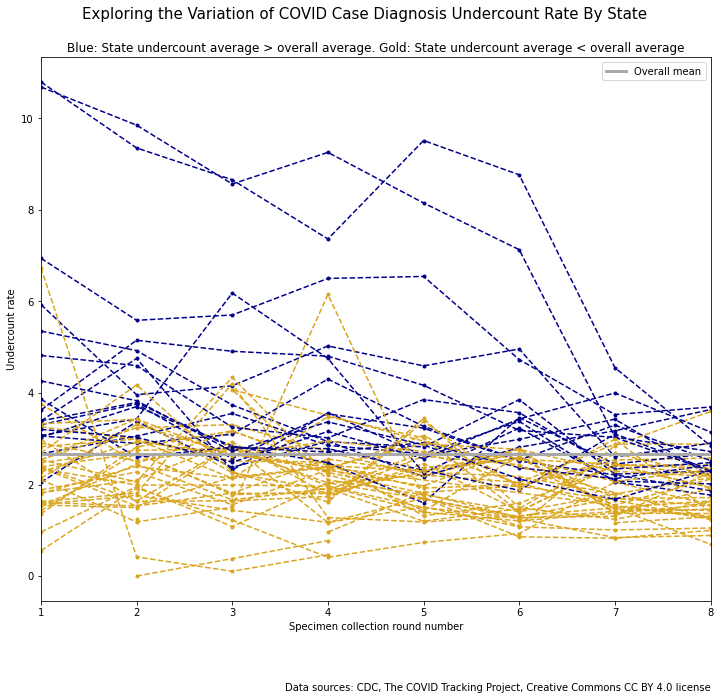

In [16]:
fig, ax = plt.subplots(figsize = (12, 10))
overall_undercount_rate = master_df['undercount_rate'].mean()
# for state in ('NY', 'PA', 'NJ', 'IL'):
# for state in ('IN', 'DC'):
for state in master_df['state'].unique():
    if master_df[master_df['state']==state][['undercount_rate']].mean()[0] > overall_undercount_rate:
        line_color = 'darkblue'
    else:
        line_color = 'goldenrod'
    ax.plot(master_df[master_df['state']==state][['Round']], 
            master_df[master_df['state']==state][['undercount_rate']], 
            color = line_color,
            ls = '--',
            marker = '.')

ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Undercount rate')
ax.set_xlim(1,8)
ax.axhline(overall_undercount_rate, label = 'Overall mean', color = 'darkgrey', lw = 3)
ax.set_title('Blue: State undercount average > overall average. Gold: State undercount average < overall average')
ax.legend()
fig.suptitle(f'Exploring the Variation of COVID Case Diagnosis Undercount Rate By State', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');


In [17]:
# Let's plot the regression coefficients (slopes) for these lines.
## Actually, plot all trend lines to show how most trend downwards, as one would expect. Those with early breakouts
## have twice the slope of change from Round 1 to Round 6.
## Can we reduce the effect of undercounting early on due to lack of test capacity? That's up next.
    
slopes = []
for state in (df_state[df_state['CVD_group']!=1]['state'].unique()):
# for state in master_df['state'].unique():
    y = master_df[master_df['state']==state]['undercount_rate']
    X = sm.add_constant(master_df[master_df['state']==state]['Round'])
    y.fillna(y.mean(), axis=0,inplace=True)
    model = sm.OLS(y, X)
    results = model.fit()
    slopes.append(results.params['Round'])
#     print(y, results.predict(), results.params['Round'])
print(slopes, sum(slopes)/ len(slopes))

[-0.0023648796171603648, -0.20108890491169198, -0.21762397806300648, -0.1557514118316949, -0.02658607985662584, -0.18548473450298808, -0.4130132299984752, 0.07390237755360635, 0.06988072909246529, -0.18898943073633673, -0.14177154724714935, 0.001176658429752342, -0.07676668163735964, -0.14307288147146965, 0.08451239129743472, -0.05352652597626956, -0.3041142458157128, -0.17070706770555882, -0.09259020226399334, 0.05413125677473804, -0.2515437929265876, -0.18402280655332923, -0.25360902708705757, -0.13473009835641536, 0.07961948449624595, -0.10310275646502659, 0.12871407332504944, -0.16077304251979574, -0.057345784055328586, -0.10453588916737422, 0.013463466973014426, -0.10317466998716407, 0.023184991099852365, -0.12985997969323052, -0.3082148642063045, -0.2276164962329822, 0.017233829550961366, 0.03603832422790129, -0.31880650868740346] -0.10586999832698642


Can we estimate a current undercount rate upper bound? Conceivably, this could be the undercount rate for states that didn't experience an early outbreak, and thus didn't have a large amount of undercounting due to lack of testing capacity in the early phase of the pandemic. There still was some undercounting due to that--we'll get to that later.

In [18]:
excludes_early_outbreak_states = master_df[master_df['state'].isin(df_state[df_state['CVD_group']!=1]['state'].unique())]

In [19]:
excludes_early_outbreak_states[excludes_early_outbreak_states['Round'].isin([7,8])].mean()['undercount_rate']

1.9946734261306645

## Recalibrate first few months.    

In [20]:
# Work with another version of the dataset. Load in the COVID Tracking Project dataset by date and by state for US
df_cases2 = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")[
                                ['date', 'state', 'fips','positiveIncrease']]

df_cases2['date'] = pd.to_datetime(df_cases2['date'], format='%Y%m%d')
df_cases2['date']

# df_cases = df_cases[df_cases['date'] >= '2020-03-10']
df_cases2 = df_cases2.sort_values('date', ascending=True)

In [21]:
df_cases2[df_cases2['date'] < '2020-05-01']['positiveIncrease']

18081       0
18080       0
18079       0
18078       0
18077       0
         ... 
14765    4681
14766     724
14767     145
14768      92
14764     100
Name: positiveIncrease, Length: 3354, dtype: int64

In [22]:
def func(x, cutoff, states):
    if pd.to_datetime(x['date']) < pd.to_datetime(cutoff):
        if x['state'] in states:
#             return x['positiveIncrease'] * 6
            return x['positiveIncrease'] * 18 / x['date'].month
        else:
            return x['positiveIncrease'] * 11 / x['date'].month
    return x['positiveIncrease']

df_cases2['positiveIncrease'] = df_cases2.apply(
                                lambda row: func(row, '2020-07-15', 
                                df_state[df_state['CVD_group']==1]['state'].unique()), axis=1)

In [23]:
df_cases2[df_cases2['date'] < '2020-05-01']['positiveIncrease']

18081        0.00
18080        0.00
18079        0.00
18078        0.00
18077        0.00
           ...   
14765    21064.50
14766     1991.00
14767      398.75
14768      253.00
14764      275.00
Name: positiveIncrease, Length: 3354, dtype: float64

In [24]:
temp_case_df = []
for round in range(len(round_dates)):
    round_df = (df_cases2[df_cases2['date'] <= round_dates.iloc[round][0]].
                   groupby('state').
                   agg(cumulative_cases = ('positiveIncrease','sum'))
                    ).reset_index()
    round_df['round'] = round + 1
    temp_case_df.append(round_df)

case_df2 = pd.concat(temp_case_df, ignore_index=True)

In [25]:
master_df2 = seroprev.merge(case_df2, left_on=['Site', 'Round'], right_on=['state', 'round'])

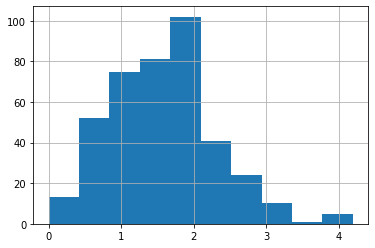

In [26]:
master_df2['undercount_rate'] = master_df2['Estimated cumulative infections count'] / master_df2['cumulative_cases']
master_df2['undercount_rate'].hist();

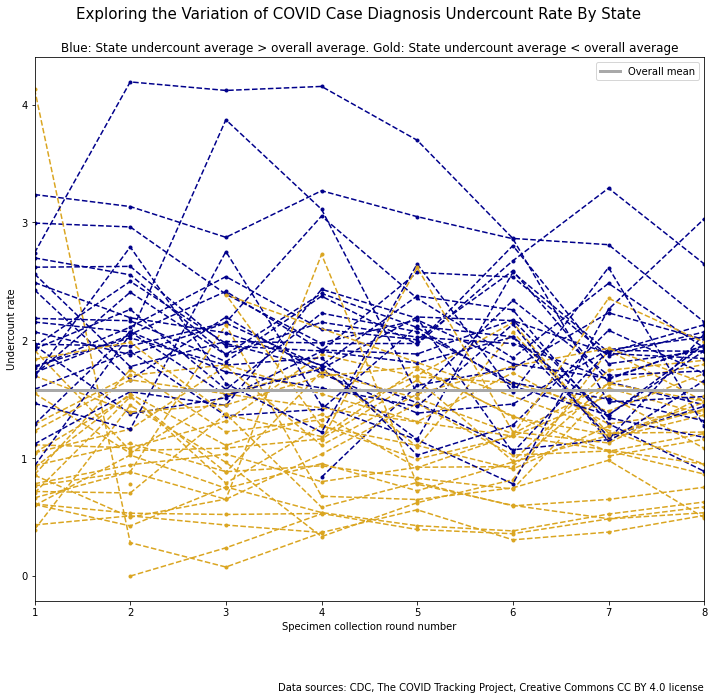

In [27]:
fig, ax = plt.subplots(figsize = (12, 10))

overall_undercount_rate = master_df2['undercount_rate'].mean()
# for state in ('MD', 'LA', 'CA'):
for state in master_df['state'].unique():
    if master_df2[master_df2['state']==state][['undercount_rate']].mean()[0] > overall_undercount_rate:
        line_color = 'darkblue'
    else:
        line_color = 'goldenrod'
    ax.plot(master_df2[master_df2['state']==state][['Round']], 
            master_df2[master_df2['state']==state][['undercount_rate']], 
            color = line_color,
            ls = '--',
            marker = '.')

ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Undercount rate')
ax.set_xlim(1,8)
ax.axhline(overall_undercount_rate, label = 'Overall mean', color = 'darkgrey', lw = 3)
ax.set_title('Blue: State undercount average > overall average. Gold: State undercount average < overall average')
ax.legend()
fig.suptitle(f'Exploring the Variation of COVID Case Diagnosis Undercount Rate By State', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');


In [28]:
# Let's plot the regression coefficients (slopes) for these lines.
    
slopes2 = []
for state in (df_state[df_state['CVD_group']==1]['state'].unique()):
# for state in master_df['state'].unique():
    y = master_df2[master_df2['state']==state]['undercount_rate']
    X = sm.add_constant(master_df2[master_df2['state']==state]['Round'])
    y.fillna(y.mean(), axis=0,inplace=True)
    model = sm.OLS(y, X)
    results = model.fit()
    slopes2.append(results.params['Round'])
#     print(y, results.predict(), results.params['Round'])
print(slopes2, sum(slopes2)/ len(slopes2))

[-0.03725506420529551, -0.01647766550637201, 0.045840764351070845, 0.12330234421732922, 0.057490382978615265, 0.013767705316150958, 0.08789715325311787, -0.006936273802416848, -0.0036977261222641347, -0.2445704013448426, -0.17295483304722795, -0.03809904028487239] -0.01597438784975061


## COVID By Age Analysis

Let's start by creating a chart of seroprevalence by age for each Round. Let's import the seroprevalence data--this time getting the age-related data.

In [29]:
seroprev_by_age = pd.read_csv('../data/Nationwide_Commercial_Laboratory_Seroprevalence_Survey_November.csv')[['Site','Date Range of Specimen Collection', 'Round', 'Catchment population', 
       'Rate (%) [0-17 Years Prevalence]', 'Rate (%) [18-49 Years Prevalence]',
       'Rate (%) [50-64 Years Prevalence]', 'Rate (%) [65+ Years Prevalence]',
       'Rate (%) [Cumulative Prevalence]', 'Estimated cumulative infections count']]

In [30]:
seroprev_by_age[seroprev_by_age['Round']==4].head()

,Site,Date Range of Specimen Collection,Round,Catchment population,Rate (%) [0-17 Years Prevalence],Rate (%) [18-49 Years Prevalence],Rate (%) [50-64 Years Prevalence],Rate (%) [65+ Years Prevalence],Rate (%) [Cumulative Prevalence],Estimated cumulative infections count
157,AK,"Sep 9 - Sep 18, 2020",4,738516,777.0,0.0,2.1,0.0,0.4,2954.0
158,AL,"Sep 9 - Sep 18, 2020",4,4864680,16.1,8.1,4.6,4.9,8.7,423227.0
159,AR,"Sep 9 - Sep 18, 2020",4,2990671,8.6,6.9,5.2,2.6,6.3,188412.0
160,AZ,"Sep 9 - Sep 23, 2020",4,6946685,777.0,9.6,4.4,0.1,5.4,375121.0
161,CA,"Sep 10 - Sep 16, 2020",4,39148760,8.1,4.7,3.6,2.1,4.9,1918289.0


In [31]:
seroprev_by_age.replace(to_replace=777,value=0,inplace=True)
seroprev_by_age.replace(to_replace=666,value=0,inplace=True)

It looks like we are going to need to calculate total estimated infections by age from the infection rate by age that is provided in the dataset. We will need to import population by age and state from Census data for this. Source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-detail.html

In [32]:
state_pop = pd.read_csv('../data/sc-est2019-agesex-civ.csv')
state_pop = state_pop[state_pop['SEX']==0][['STATE','NAME','AGE','POPEST2019_CIV']]

In [33]:
state_pop_groups = state_pop.groupby('STATE').agg(st_fips = ('STATE', 'max'),
                                                  st_name = ('NAME', 'max')).reset_index()

del state_pop_groups['STATE']

In [34]:
state_pop_01_17 = (state_pop[state_pop['AGE'].isin(range(0,18))].
                   groupby('STATE').sum()['POPEST2019_CIV'].reset_index())
state_pop_18_49 = (state_pop[state_pop['AGE'].isin(range(18,50))].
                   groupby('STATE')['POPEST2019_CIV'].sum().reset_index())
state_pop_50_64 = (state_pop[state_pop['AGE'].isin(range(50,65))].
                   groupby('STATE')['POPEST2019_CIV'].sum().reset_index())
state_pop_65_plus = (state_pop[state_pop['AGE'].isin(range(65,100))].
                     groupby('STATE')['POPEST2019_CIV'].sum().reset_index())

In [35]:
state_pop_groups['state_pop_01_17'] = state_pop_01_17['POPEST2019_CIV']
state_pop_groups['state_pop_18_49'] = state_pop_18_49['POPEST2019_CIV']
state_pop_groups['state_pop_50_64'] = state_pop_50_64['POPEST2019_CIV']
state_pop_groups['state_pop_65_plus'] = state_pop_65_plus['POPEST2019_CIV']


The state field in the seroprevalence table ('Site') does not match the format of the state fields in the census table ('st+abbr' or 'st_name') so we are going to need to load in another table to allow us to join our data. 

In [36]:
state_pop_groups2 = state_pop_groups.merge(df_state.groupby('state').max().reset_index(), 
                                           left_on = 'st_fips', right_on = 'fips')[
                ['st_name', 'state', 'fips', 'state_pop_01_17', 'state_pop_18_49',
       'state_pop_50_64', 'state_pop_65_plus']]

In [37]:
state_pop_groups2.head(2)

,st_name,state,fips,state_pop_01_17,state_pop_18_49,state_pop_50_64,state_pop_65_plus
0,Alabama,AL,1,1088286,1986417,964807,849837
1,Alaska,AK,2,179983,304569,135974,91588


In [38]:
seroprev_by_age_new = seroprev_by_age.merge(state_pop_groups2, left_on = 'Site', right_on = 'state')

In [39]:
seroprev_by_age_new.columns

Index(['Site', 'Date Range of Specimen Collection', 'Round',
       'Catchment population', 'Rate (%) [0-17 Years Prevalence]',
       'Rate (%) [18-49 Years Prevalence]',
       'Rate (%) [50-64 Years Prevalence]', 'Rate (%) [65+ Years Prevalence]',
       'Rate (%) [Cumulative Prevalence]',
       'Estimated cumulative infections count', 'st_name', 'state', 'fips',
       'state_pop_01_17', 'state_pop_18_49', 'state_pop_50_64',
       'state_pop_65_plus'],
      dtype='object')

In [40]:
seroprev_by_age_new.head()

,Site,Date Range of Specimen Collection,Round,Catchment population,Rate (%) [0-17 Years Prevalence],Rate (%) [18-49 Years Prevalence],Rate (%) [50-64 Years Prevalence],Rate (%) [65+ Years Prevalence],Rate (%) [Cumulative Prevalence],Estimated cumulative infections count,st_name,state,fips,state_pop_01_17,state_pop_18_49,state_pop_50_64,state_pop_65_plus
0,AK,"Aug 6 - Aug 11, 2020",1,738516,0.0,0.7,0.0,0.0,0.3,2216.0,Alaska,AK,2,179983,304569,135974,91588
1,AK,"Aug 12 - Aug 26, 2020",2,738516,0.0,2.5,0.8,0.0,1.3,9601.0,Alaska,AK,2,179983,304569,135974,91588
2,AK,"Aug 26 - Sep 9, 2020",3,738516,0.0,1.6,1.4,0.5,1.0,7385.0,Alaska,AK,2,179983,304569,135974,91588
3,AK,"Sep 9 - Sep 18, 2020",4,738516,0.0,0.0,2.1,0.0,0.4,2954.0,Alaska,AK,2,179983,304569,135974,91588
4,AK,"Sep 22 - Oct 7, 2020",5,738516,0.0,1.1,1.7,1.1,0.9,6647.0,Alaska,AK,2,179983,304569,135974,91588


In [41]:
seroprev_by_age_new['est_infections_0_17'] = (seroprev_by_age_new['Rate (%) [0-17 Years Prevalence]'] * 
                                              seroprev_by_age_new['state_pop_01_17']) / 100
seroprev_by_age_new['est_infections_18_49'] = (seroprev_by_age_new['Rate (%) [18-49 Years Prevalence]'] * 
                                              seroprev_by_age_new['state_pop_18_49']) / 100
seroprev_by_age_new['est_infections_50_64'] = (seroprev_by_age_new['Rate (%) [50-64 Years Prevalence]'] * 
                                              seroprev_by_age_new['state_pop_50_64']) / 100
seroprev_by_age_new['est_infections_65_plus'] = (seroprev_by_age_new['Rate (%) [65+ Years Prevalence]'] * 
                                              seroprev_by_age_new['state_pop_65_plus']) / 100

In [42]:
seroprev_by_age_new.head()

,Site,Date Range of Specimen Collection,Round,Catchment population,Rate (%) [0-17 Years Prevalence],Rate (%) [18-49 Years Prevalence],Rate (%) [50-64 Years Prevalence],Rate (%) [65+ Years Prevalence],Rate (%) [Cumulative Prevalence],Estimated cumulative infections count,...,state,fips,state_pop_01_17,state_pop_18_49,state_pop_50_64,state_pop_65_plus,est_infections_0_17,est_infections_18_49,est_infections_50_64,est_infections_65_plus
0,AK,"Aug 6 - Aug 11, 2020",1,738516,0.0,0.7,0.0,0.0,0.3,2216.0,...,AK,2,179983,304569,135974,91588,0.0,2131.983,0.000,0.000
1,AK,"Aug 12 - Aug 26, 2020",2,738516,0.0,2.5,0.8,0.0,1.3,9601.0,...,AK,2,179983,304569,135974,91588,0.0,7614.225,1087.792,0.000
2,AK,"Aug 26 - Sep 9, 2020",3,738516,0.0,1.6,1.4,0.5,1.0,7385.0,...,AK,2,179983,304569,135974,91588,0.0,4873.104,1903.636,457.940
3,AK,"Sep 9 - Sep 18, 2020",4,738516,0.0,0.0,2.1,0.0,0.4,2954.0,...,AK,2,179983,304569,135974,91588,0.0,0.000,2855.454,0.000
4,AK,"Sep 22 - Oct 7, 2020",5,738516,0.0,1.1,1.7,1.1,0.9,6647.0,...,AK,2,179983,304569,135974,91588,0.0,3350.259,2311.558,1007.468


In [43]:
seroprev_by_age_new['date_range_top'] = pd.to_datetime(seroprev_by_age_new['Date Range of Specimen Collection'].
                                str[-12:].str.strip())
round_dates = (seroprev_by_age_new.groupby('Round').agg(
                                date_range_top = ('date_range_top', 'max'))
                                ) #.reset_index()

In [44]:
seroprev_by_age_new

,Site,Date Range of Specimen Collection,Round,Catchment population,Rate (%) [0-17 Years Prevalence],Rate (%) [18-49 Years Prevalence],Rate (%) [50-64 Years Prevalence],Rate (%) [65+ Years Prevalence],Rate (%) [Cumulative Prevalence],Estimated cumulative infections count,...,fips,state_pop_01_17,state_pop_18_49,state_pop_50_64,state_pop_65_plus,est_infections_0_17,est_infections_18_49,est_infections_50_64,est_infections_65_plus,date_range_top
0,AK,"Aug 6 - Aug 11, 2020",1,738516,0.0,0.7,0.0,0.0,0.3,2216.0,...,2,179983,304569,135974,91588,0.0,2131.983,0.000,0.000,2020-08-11
1,AK,"Aug 12 - Aug 26, 2020",2,738516,0.0,2.5,0.8,0.0,1.3,9601.0,...,2,179983,304569,135974,91588,0.0,7614.225,1087.792,0.000,2020-08-26
2,AK,"Aug 26 - Sep 9, 2020",3,738516,0.0,1.6,1.4,0.5,1.0,7385.0,...,2,179983,304569,135974,91588,0.0,4873.104,1903.636,457.940,2020-09-09
3,AK,"Sep 9 - Sep 18, 2020",4,738516,0.0,0.0,2.1,0.0,0.4,2954.0,...,2,179983,304569,135974,91588,0.0,0.000,2855.454,0.000,2020-09-18
4,AK,"Sep 22 - Oct 7, 2020",5,738516,0.0,1.1,1.7,1.1,0.9,6647.0,...,2,179983,304569,135974,91588,0.0,3350.259,2311.558,1007.468,2020-10-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,WY,"Sep 9 - Sep 24, 2020",4,581836,0.0,0.0,0.0,0.0,1.5,8728.0,...,56,133734,232649,110103,99179,0.0,0.000,0.000,0.000,2020-09-24
404,WY,"Sep 23 - Oct 7, 2020",5,581836,0.0,0.0,0.0,0.0,4.2,24437.0,...,56,133734,232649,110103,99179,0.0,0.000,0.000,0.000,2020-10-07
405,WY,"Oct 8 - Oct 21, 2020",6,581836,0.0,0.0,0.0,0.0,2.6,15128.0,...,56,133734,232649,110103,99179,0.0,0.000,0.000,0.000,2020-10-21
406,WY,"Oct 26 - Nov 10, 2020",7,581836,0.0,5.2,4.0,7.2,4.8,27928.0,...,56,133734,232649,110103,99179,0.0,12097.748,4404.120,7140.888,2020-11-10


In [147]:
seroprev_US = seroprev_by_age_new.groupby('Round').agg(
                                    pop_0_17 = ('state_pop_01_17', 'sum'),
                                    pop_18_49 = ('state_pop_18_49', 'sum'),
                                    pop_50_64 = ('state_pop_50_64', 'sum'),
                                    pop_65_plus = ('state_pop_65_plus', 'sum'),
                                    est_infections_0_17 = ('est_infections_0_17', 'sum'),
                                    est_infections_18_49 = ('est_infections_18_49', 'sum'),
                                    est_infections_50_64 = ('est_infections_50_64', 'sum'),
                                    est_infections_65_plus = ('est_infections_65_plus', 'sum'),
                                    est_infections_from_table = ('Estimated cumulative infections count', 'sum'),
                                    last_date_of_round = ('date_range_top', 'max')
                                ).reset_index()

In [148]:
seroprev_US['pct_age_data_missing'] = (seroprev_US['est_infections_from_table'] - 
                                       seroprev_US['est_infections_0_17'] - 
                                       seroprev_US['est_infections_18_49'] - 
                                       seroprev_US['est_infections_50_64'] - 
                                       seroprev_US['est_infections_65_plus'] ) / seroprev_US['est_infections_from_table']

In [149]:
seroprev_US

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,est_infections_0_17,est_infections_18_49,est_infections_50_64,est_infections_65_plus,est_infections_from_table,last_date_of_round,pct_age_data_missing
0,1,73037927,137050390,62906022,54058263,4661340.628,9.655833e+06,3219386.452,1309804.316,19987259.0,2020-08-13,0.057081
1,2,73037927,137050390,62906022,54058263,4361594.170,9.549073e+06,3143754.333,1855736.778,19802466.0,2020-08-27,0.045060
2,3,73037927,137050390,62906022,54058263,4668091.053,1.000844e+07,3831199.817,1763457.688,20878315.0,2020-09-10,0.029079
3,4,73037927,137050390,62906022,54058263,6087073.635,1.058429e+07,3386356.438,1642508.391,22457026.0,2020-09-24,0.033700
4,5,73037927,137050390,62906022,54058263,5307331.898,1.095296e+07,3610665.036,1893742.501,23132170.0,2020-10-08,0.059116
5,6,73037927,137050390,62906022,54058263,4879188.179,1.240094e+07,4023127.643,2103140.553,24071653.0,2020-10-22,0.027636
6,7,73037927,137050390,62906022,54058263,5064134.209,1.361315e+07,4408069.429,2115912.077,28136836.0,2020-11-15,0.104332
7,8,73037927,137050390,62906022,54058263,6485300.322,1.483486e+07,5266290.058,2900956.567,31460706.0,2020-11-29,0.062723


In [150]:
seroprev_US['est_infections_rate_0_17'] = (seroprev_US['est_infections_0_17'] / seroprev_US['pop_0_17'] /
                                           (1-seroprev_US['pct_age_data_missing']))
seroprev_US['est_infections_rate_18_49'] = (seroprev_US['est_infections_18_49'] / seroprev_US['pop_18_49'] /
                                           (1-seroprev_US['pct_age_data_missing']))
seroprev_US['est_infections_rate_50_64'] = (seroprev_US['est_infections_50_64'] / seroprev_US['pop_50_64'] /
                                           (1-seroprev_US['pct_age_data_missing']))
seroprev_US['est_infections_rate_65_plus'] = (seroprev_US['est_infections_65_plus'] / seroprev_US['pop_65_plus'] /
                                           (1-seroprev_US['pct_age_data_missing']))

In [151]:
seroprev_US

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,est_infections_0_17,est_infections_18_49,est_infections_50_64,est_infections_65_plus,est_infections_from_table,last_date_of_round,pct_age_data_missing,est_infections_rate_0_17,est_infections_rate_18_49,est_infections_rate_50_64,est_infections_rate_65_plus
0,1,73037927,137050390,62906022,54058263,4661340.628,9.655833e+06,3219386.452,1309804.316,19987259.0,2020-08-13,0.057081,0.067684,0.074720,0.054276,0.025696
1,2,73037927,137050390,62906022,54058263,4361594.170,9.549073e+06,3143754.333,1855736.778,19802466.0,2020-08-27,0.045060,0.062535,0.072963,0.052334,0.035948
2,3,73037927,137050390,62906022,54058263,4668091.053,1.000844e+07,3831199.817,1763457.688,20878315.0,2020-09-10,0.029079,0.065827,0.075215,0.062728,0.033598
3,4,73037927,137050390,62906022,54058263,6087073.635,1.058429e+07,3386356.438,1642508.391,22457026.0,2020-09-24,0.033700,0.086248,0.079923,0.055709,0.031444
4,5,73037927,137050390,62906022,54058263,5307331.898,1.095296e+07,3610665.036,1893742.501,23132170.0,2020-10-08,0.059116,0.077231,0.084941,0.061004,0.037233
5,6,73037927,137050390,62906022,54058263,4879188.179,1.240094e+07,4023127.643,2103140.553,24071653.0,2020-10-22,0.027636,0.068702,0.093056,0.065772,0.040011
6,7,73037927,137050390,62906022,54058263,5064134.209,1.361315e+07,4408069.429,2115912.077,28136836.0,2020-11-15,0.104332,0.077412,0.110900,0.078236,0.043701
7,8,73037927,137050390,62906022,54058263,6485300.322,1.483486e+07,5266290.058,2900956.567,31460706.0,2020-11-29,0.062723,0.094736,0.115488,0.089319,0.057255


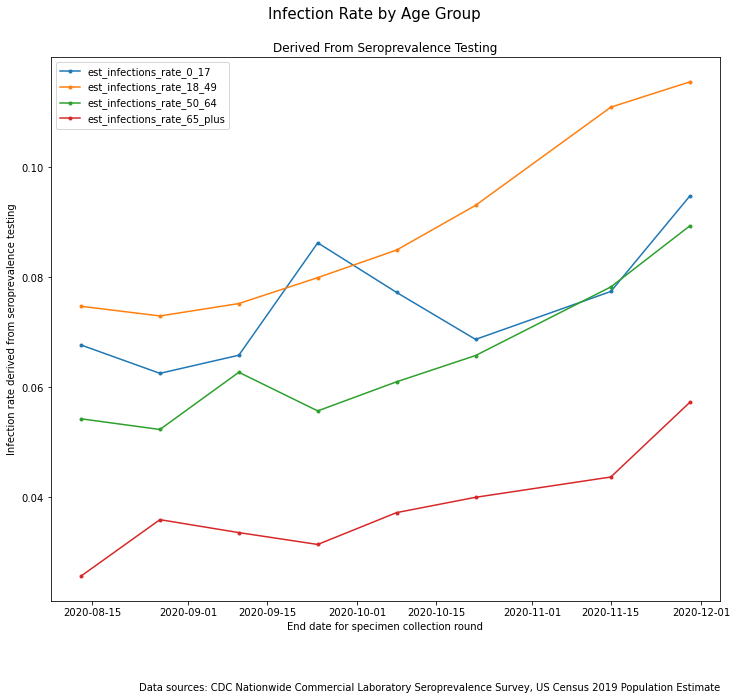

In [173]:
# In order to turn the x axis into dates, we'll need to merge Round to dates to get dates into the seroprev_US dataframe.

fig, ax = plt.subplots(figsize = (12, 10))
# seroprev_US.set_index('last_date_of_round', inplace=True)

for col_name in ['est_infections_rate_0_17', 'est_infections_rate_18_49', 'est_infections_rate_50_64', 'est_infections_rate_65_plus']:
    ax.plot(seroprev_US['last_date_of_round'],
            seroprev_US[col_name], 
            label = col_name,
            marker = '.')

ax.set_xlabel('End date for specimen collection round')
ax.set_ylabel('Infection rate derived from seroprevalence testing')
ax.set_title('Derived From Seroprevalence Testing')
ax.legend()
fig.suptitle(f'Infection Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right');

Now we need to do the same thing with the case data--calculate the case rate by age group. Let's start by summing up cumulative cases for each age group in the CDC data. We'll loop through the data 8 times--once for each of the specimen collection rounds. For each loop, we'll cut off the count at the date corresponding to that particular specimen collection round's cutoff date. We will need to transpose our table and then convert the age groups from the CDC data to match the age groups for the seroprevalence data.

We're also going to need to pull in estimated population from the US Census so we can calculate infection rates.

In [153]:
rows_ = 15000000 #dataset is large. Need to limit rows and/or columns to load.
CDC_case_df = pd.read_csv('../data/COVID-19_Case_Surveillance_Public_Use_Data.csv', 
                          usecols=[0,5,6,10 ], encoding='latin-1', nrows=rows_)
# Source: https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf/data

In [154]:
pct_unknowns = CDC_case_df[CDC_case_df['age_group']=='Unknown'].count()['age_group'] / CDC_case_df.count()['age_group']

In [155]:
pct_unknowns # less than 1% unknowns.

0.006094022184339774

In [156]:
CDC_case_df = CDC_case_df[CDC_case_df['age_group']!='Unknown']

In [157]:
CDC_case_df[CDC_case_df['age_group'].isna()].count()

cdc_case_earliest_dt     66
sex                      54
age_group                 0
death_yn                 66
dtype: int64

In [158]:
pd.to_datetime(CDC_case_df['cdc_case_earliest_dt '])

0          2020-03-23
1          2020-03-22
2          2020-03-22
3          2020-03-23
4          2020-03-23
              ...    
13415831   2020-12-16
13415832   2020-12-10
13415833   2020-12-14
13415834   2020-12-15
13415835   2020-12-16
Name: cdc_case_earliest_dt , Length: 13334080, dtype: datetime64[ns]

In [159]:
age_group_df = pd.DataFrame(CDC_case_df['age_group'].unique(), columns=['age_group'])
round_ = 1

for date_ in seroprev_US['last_date_of_round']:
    curr_case_df = (CDC_case_df[pd.to_datetime(CDC_case_df['cdc_case_earliest_dt ']) < date_].
                    groupby('age_group').count()
                    )
    curr_case_df = curr_case_df.rename(columns={'sex': round_})[round_].reset_index()
    round_ +=1
    age_group_df = age_group_df.merge(curr_case_df, on='age_group')
print(age_group_df)

       age_group       1       2        3        4        5        6        7  \
0    0 - 9 Years  136879  157158   173896   191639   213529   242774   332999   
1  10 - 19 Years  337647  397479   469127   530630   595154   671935   910381   
2  20 - 29 Years  838176  940622  1050777  1146590  1250367  1379106  1782626   
3  30 - 39 Years  748616  825164   893142   960546  1041963  1151668  1494870   
4  50 - 59 Years  664964  730357   790778   849947   922455  1022653  1324608   
5  60 - 69 Years  461850  505775   547523   588545   641464   713790   929715   
6  40 - 49 Years  689806  759190   822433   883467   957709  1058702  1372523   
7      80+ Years  236689  254095   271325   287237   307631   334887   412369   
8  70 - 79 Years  258185  282818   306647   330076   361045   402121   520592   

         8  
0   405375  
1  1089396  
2  2090341  
3  1768635  
4  1569347  
5  1105960  
6  1623010  
7   478465  
8   618418  


In [160]:
#     curr_case_df = curr_case_df.rename(columns={'sex': round_}, inplace=True)
# print(curr_case_df.rename({'sex': 'more_sex'},axis=1,inplace=True))
age_group_df = age_group_df.T
age_group_df.columns = age_group_df.iloc[0]
age_group_df = age_group_df[1:]
age_group_df = age_group_df.reset_index().rename(columns={'index':'Round'})

In [161]:
age_group_df

age_group,Round,0 - 9 Years,10 - 19 Years,20 - 29 Years,30 - 39 Years,50 - 59 Years,60 - 69 Years,40 - 49 Years,80+ Years,70 - 79 Years
0,1,136879,337647,838176,748616,664964,461850,689806,236689,258185
1,2,157158,397479,940622,825164,730357,505775,759190,254095,282818
2,3,173896,469127,1050777,893142,790778,547523,822433,271325,306647
3,4,191639,530630,1146590,960546,849947,588545,883467,287237,330076
4,5,213529,595154,1250367,1041963,922455,641464,957709,307631,361045
5,6,242774,671935,1379106,1151668,1022653,713790,1058702,334887,402121
6,7,332999,910381,1782626,1494870,1324608,929715,1372523,412369,520592
7,8,405375,1089396,2090341,1768635,1569347,1105960,1623010,478465,618418


In [162]:
age_group_df['cases_0_17'] = (age_group_df['0 - 9 Years'] + 
                              4/5 * age_group_df['10 - 19 Years'])
age_group_df['cases_18_49'] = (1/5 * age_group_df['10 - 19 Years'] + 
                               age_group_df['20 - 29 Years'] + 
                               age_group_df['30 - 39 Years'] +
                               age_group_df['40 - 49 Years'])
age_group_df['cases_50_64'] = (age_group_df['50 - 59 Years'] + 
                               1/2 * age_group_df['60 - 69 Years'])
age_group_df['cases_65_plus'] = (1/2* age_group_df['60 - 69 Years'] + 
                               age_group_df['70 - 79 Years'] + 
                               age_group_df['80+ Years'])

In [163]:
age_group_df[['cases_0_17', 'cases_18_49', 'cases_50_64', 'cases_65_plus']]

age_group,cases_0_17,cases_18_49,cases_50_64,cases_65_plus
0,406997,2.34413e+06,895889,725799
1,475141,2.60447e+06,983244,789800
2,549198,2.86018e+06,1.06454e+06,851734
3,616143,3.09673e+06,1.14422e+06,911586
4,689652,3.36907e+06,1.24319e+06,989408
5,780322,3.72386e+06,1.37955e+06,1.0939e+06
6,1.0613e+06,4.8321e+06,1.78947e+06,1.39782e+06
7,1.27689e+06,5.69987e+06,2.12233e+06,1.64986e+06


In [164]:
seroprev_US = seroprev_US.merge(age_group_df, on='Round')

In [165]:

seroprev_US['est_infections_from_cases_rate_0_17'] = (seroprev_US['cases_0_17'] / seroprev_US['pop_0_17'] /
                                           (1-pct_unknowns))
seroprev_US['est_infections_from_cases_rate_18_49'] = (seroprev_US['cases_18_49'] / seroprev_US['pop_18_49'] /
                                           (1-pct_unknowns))
seroprev_US['est_infections_from_cases_rate_50_64'] = (seroprev_US['cases_50_64'] / seroprev_US['pop_50_64'] /
                                           (1-pct_unknowns))
seroprev_US['est_infections_from_cases_rate_65_plus'] = (seroprev_US['cases_65_plus'] / seroprev_US['pop_65_plus'] /
                                           (1-pct_unknowns))

In [206]:
print(seroprev_US['est_infections_65_plus'], seroprev_US['cases_65_plus'])

0    1309804.316
1    1855736.778
2    1763457.688
3    1642508.391
4    1893742.501
5    2103140.553
6    2115912.077
7    2900956.567
Name: est_infections_65_plus, dtype: float64 0         725799
1         789800
2         851734
3         911586
4         989408
5     1.0939e+06
6    1.39782e+06
7    1.64986e+06
Name: cases_65_plus, dtype: object


In [207]:
seroprev_US['undercount_rate_0_17'] = (seroprev_US['est_infections_0_17'] / 
                                       seroprev_US['cases_0_17'])
seroprev_US['undercount_rate_18_49'] = (seroprev_US['est_infections_18_49'] / 
                                        seroprev_US['cases_18_49'])
seroprev_US['undercount_rate_50_64'] = (seroprev_US['est_infections_50_64'] / 
                                        seroprev_US['cases_50_64'])
seroprev_US['undercount_rate_65_plus'] = (seroprev_US['est_infections_65_plus'] / 
                                          seroprev_US['cases_65_plus'])

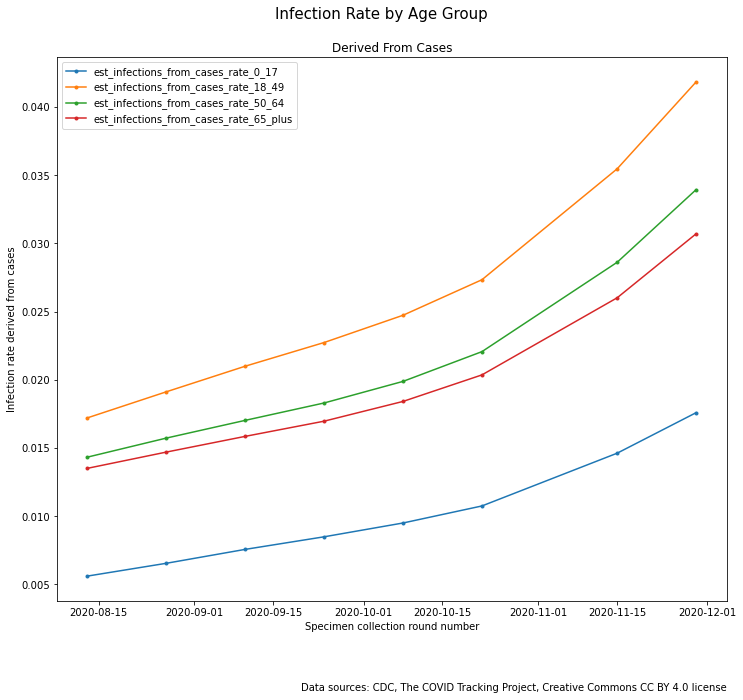

In [208]:
fig, ax = plt.subplots(figsize = (12, 10))

for col_name in ['est_infections_from_cases_rate_0_17', 'est_infections_from_cases_rate_18_49', 
                 'est_infections_from_cases_rate_50_64', 'est_infections_from_cases_rate_65_plus']:
    ax.plot(seroprev_US['last_date_of_round'],
            seroprev_US[col_name], 
            label = col_name,
            marker = '.')

ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Infection rate derived from cases')
ax.set_title('Derived From Cases')
ax.legend()
fig.suptitle(f'Infection Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');

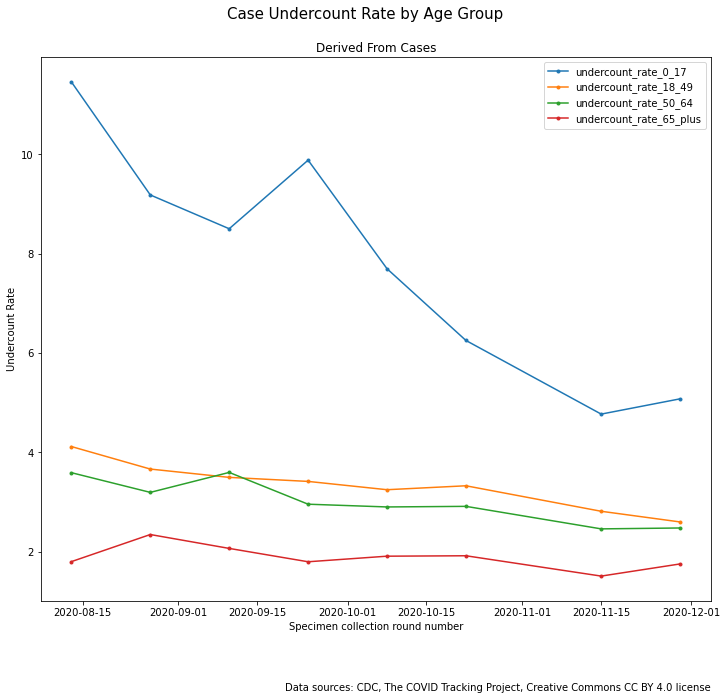

In [209]:
fig, ax = plt.subplots(figsize = (12, 10))

for col_name in ['undercount_rate_0_17', 'undercount_rate_18_49', 
                 'undercount_rate_50_64', 'undercount_rate_65_plus']:
    ax.plot(seroprev_US['last_date_of_round'],
            seroprev_US[col_name], 
            label = col_name,
            marker = '.')

ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Undercount Rate')
ax.set_title('Derived From Cases')
ax.legend()
fig.suptitle(f'Case Undercount Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');

Add in confidence intervals, statistical tests to describe how likely it is that the observed trends reflect actual trends. 

Try to come up with an estimate of how undercount rates by age have changed over time. Will need to estimate the undercount before August?

In [210]:
seroprev_US

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,est_infections_0_17,est_infections_18_49,est_infections_50_64,est_infections_65_plus,est_infections_from_table,...,cases_50_64,cases_65_plus,est_infections_from_cases_rate_0_17,est_infections_from_cases_rate_18_49,est_infections_from_cases_rate_50_64,est_infections_from_cases_rate_65_plus,undercount_rate_0_17,undercount_rate_18_49,undercount_rate_50_64,undercount_rate_65_plus
0,1,73037927,137050390,62906022,54058263,4661340.628,9.655833e+06,3219386.452,1309804.316,19987259.0,...,895889,725799,0.00560657,0.017209,0.014329,0.0135086,11.453,4.11916,3.59351,1.80464
1,2,73037927,137050390,62906022,54058263,4361594.170,9.549073e+06,3143754.333,1855736.778,19802466.0,...,983244,789800,0.00654529,0.0191203,0.0157262,0.0146998,9.17957,3.66641,3.19733,2.34963
2,3,73037927,137050390,62906022,54058263,4668091.053,1.000844e+07,3831199.817,1763457.688,20878315.0,...,1.06454e+06,851734,0.00756545,0.0209975,0.0170265,0.0158524,8.49984,3.49924,3.59893,2.07043
3,4,73037927,137050390,62906022,54058263,6087073.635,1.058429e+07,3386356.438,1642508.391,22457026.0,...,1.14422e+06,911586,0.00848766,0.0227341,0.0183009,0.0169664,9.87932,3.41789,2.95953,1.80181
4,5,73037927,137050390,62906022,54058263,5307331.898,1.095296e+07,3610665.036,1893742.501,23132170.0,...,1.24319e+06,989408,0.00950028,0.0247334,0.0198838,0.0184148,7.69566,3.25103,2.90436,1.91402
5,6,73037927,137050390,62906022,54058263,4879188.179,1.240094e+07,4023127.643,2103140.553,24071653.0,...,1.37955e+06,1.0939e+06,0.0107493,0.0273381,0.0220648,0.0203597,6.25279,3.33013,2.91627,1.9226
6,7,73037927,137050390,62906022,54058263,5064134.209,1.361315e+07,4408069.429,2115912.077,28136836.0,...,1.78947e+06,1.39782e+06,0.01462,0.035474,0.0286211,0.0260162,4.77162,2.81724,2.46334,1.51372
7,8,73037927,137050390,62906022,54058263,6485300.322,1.483486e+07,5266290.058,2900956.567,31460706.0,...,2.12233e+06,1.64986e+06,0.0175898,0.0418446,0.0339449,0.0307072,5.07897,2.60267,2.48138,1.7583


In [211]:
seroprev_US.columns 
cols =['est_infections_0_17', 'est_infections_18_49', 'est_infections_50_64',
       'est_infections_65_plus', 'est_infections_from_table', 'cases_0_17', 'cases_18_49', 'cases_50_64',
       'cases_65_plus']

In [218]:
for col in cols:
    baseline = (seroprev_US[col][0] + seroprev_US[col][1]) / 2
    new_name = col + '_change_from_base'
    seroprev_US[new_name] = seroprev_US[col] - baseline

In [219]:
seroprev_US

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,est_infections_0_17,est_infections_18_49,est_infections_50_64,est_infections_65_plus,est_infections_from_table,...,change_from_basecases_65_plus,est_infections_0_17_change_from_base,est_infections_18_49_change_from_base,est_infections_50_64_change_from_base,est_infections_65_plus_change_from_base,est_infections_from_table_change_from_base,cases_0_17_change_from_base,cases_18_49_change_from_base,cases_50_64_change_from_base,cases_65_plus_change_from_base
0,1,73037927,137050390,62906022,54058263,4661340.628,9.655833e+06,3219386.452,1309804.316,19987259.0,...,-32000.8,149873.229,5.337976e+04,3.781606e+04,-272966.231,92396.5,-34072.3,-130172,-43677.8,-32000.8
1,2,73037927,137050390,62906022,54058263,4361594.170,9.549073e+06,3143754.333,1855736.778,19802466.0,...,32000.8,-149873.229,-5.337976e+04,-3.781606e+04,272966.231,-92396.5,34072.3,130172,43677.8,32000.8
2,3,73037927,137050390,62906022,54058263,4668091.053,1.000844e+07,3831199.817,1763457.688,20878315.0,...,93933.8,156623.654,4.059866e+05,6.496294e+05,180687.141,983452.5,108129,385878,124973,93933.8
3,4,73037927,137050390,62906022,54058263,6087073.635,1.058429e+07,3386356.438,1642508.391,22457026.0,...,153786,1575606.236,9.818385e+05,2.047860e+05,59737.844,2562163.5,175074,622429,204653,153786
4,5,73037927,137050390,62906022,54058263,5307331.898,1.095296e+07,3610665.036,1893742.501,23132170.0,...,231608,795864.499,1.350507e+06,4.290946e+05,310971.954,3237307.5,248583,894770,303620,231608
5,6,73037927,137050390,62906022,54058263,4879188.179,1.240094e+07,4023127.643,2103140.553,24071653.0,...,336103,367720.780,2.798492e+06,8.415573e+05,520370.006,4176790.5,339253,1.24956e+06,439981,336103
6,7,73037927,137050390,62906022,54058263,5064134.209,1.361315e+07,4408069.429,2115912.077,28136836.0,...,640019,552666.810,4.010701e+06,1.226499e+06,533141.530,8241973.5,620235,2.3578e+06,849899,640019
7,8,73037927,137050390,62906022,54058263,6485300.322,1.483486e+07,5266290.058,2900956.567,31460706.0,...,892063,1973832.923,5.232410e+06,2.084720e+06,1318186.020,11565843.5,835823,3.22557e+06,1.18276e+06,892063


In [220]:
seroprev_US['from_August_undercount_rate_0_17'] = (seroprev_US['est_infections_0_17_change_from_base'] / 
                                       seroprev_US['cases_0_17_change_from_base'])
seroprev_US['from_August_undercount_rate_18_49'] = (seroprev_US['est_infections_18_49_change_from_base'] / 
                                        seroprev_US['cases_18_49_change_from_base'])
seroprev_US['from_August_undercount_rate_50_64'] = (seroprev_US['est_infections_50_64_change_from_base'] / 
                                        seroprev_US['cases_50_64_change_from_base'])
seroprev_US['from_August_undercount_rate_65_plus'] = (seroprev_US['est_infections_65_plus_change_from_base'] / 
                                          seroprev_US['cases_65_plus_change_from_base'])

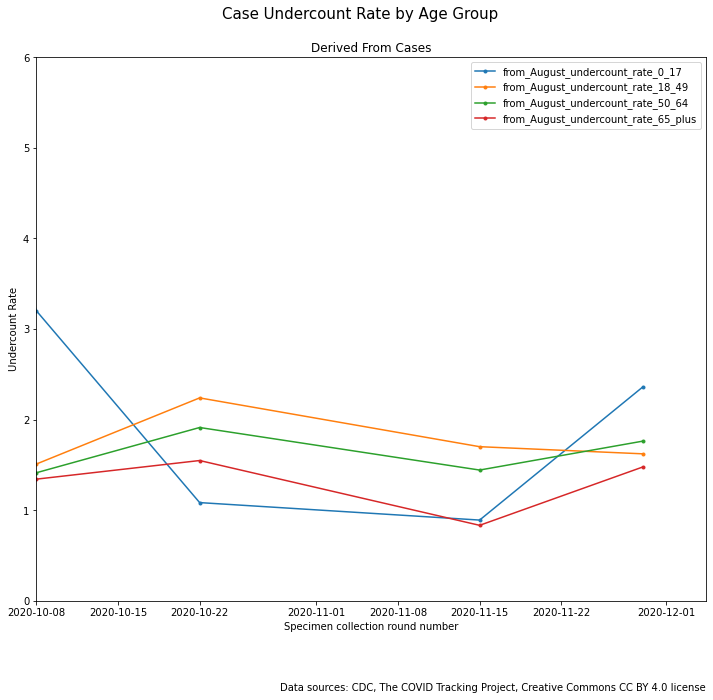

In [227]:
fig, ax = plt.subplots(figsize = (12, 10))

for col_name in ['from_August_undercount_rate_0_17', 'from_August_undercount_rate_18_49', 
                 'from_August_undercount_rate_50_64', 'from_August_undercount_rate_65_plus']:
    ax.plot(seroprev_US['last_date_of_round'],
            seroprev_US[col_name], 
            label = col_name,
            marker = '.')

ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Undercount Rate')
ax.set_title('Derived From Cases')
ax.set_xlim(left=seroprev_US['last_date_of_round'][4])
ax.set_ylim(0,6)
ax.legend()
fig.suptitle(f'Case Undercount Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');